In [ ]:
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigs
import numpy as np
import networkx as nx

import os
import pickle

city1 = nx.convert_node_labels_to_integers(nx.grid_2d_graph(4, 4), first_label=0)
city2 =  nx.convert_node_labels_to_integers(nx.grid_2d_graph(4, 4), first_label=16)
road = nx.convert_node_labels_to_integers(nx.path_graph(10), first_label=32)
city1.add_edge(15, 32)
city2.add_edge(16, 41)

G = nx.compose_all([city1, city2, road])
G = nx.convert_node_labels_to_integers(G)

#plt.figure(figsize=(10, 6))
#nx.draw(G, node_color=[0 for node in G.nodes], node_size = 35, pos = nx.spring_layout(G))
#plt.show()

eigenvalues, _ = eigs(nx.adjacency_matrix(G).astype(np.float64), k=1, which='LM')
max_alpha = 1 / np.abs(eigenvalues).max()

alpha=0.5*max_alpha
beta=1
print(G)
print("Alpha:", alpha)

In [ ]:
from anonymigraph.metrics.evaluator import Evaluator
from anonymigraph.metrics.utility.structural.privacy_metrics import PercentageKDegreeAnonMetric

from anonymigraph.metrics.utility.structural import (
    DegreeCentralityMetric,
    EigenvectorMetric,
    PageRankMetric,
    ClosenessCentralityMetric,
    LocalClusteringCoefficientMetric,
    WLColorMetric,

    ConnectedComponentsMetric,
    NumberOfEdgesMetric,
    NumberOfNodesMetric,
    NumberOfTrianglesMetric,
    MeanDegreeMetric,
    MaxDegreeMetric,
    MedianDegreeMetric,
    AverageClusteringCoefficientMetric,
    TransitivityMetric,

    EdgeJaccardMetric,
    KatzCentralityMetric,

)

from anonymigraph.anonymization import (
    KDegreeAnonymizer,
    RandomEdgeAddDelAnonymizer,
    ConfigurationModelAnonymizer,
    NestModelAnonymizer,
    PygmalionModelAnonymizer,
    PrivateColorAnonymizer,
    PrivateClosenessColors,
)


closeness_synth = []
for seed in range(55, 55+20): # 4 samples with different seeds
    # METRICS
    metrics = {
        # Important
        # Graph Level
        #"|Δ|": NumberOfTrianglesMetric(),
        #"Transitivity": TransitivityMetric(),

        # Node Level
        "Katz": KatzCentralityMetric(alpha=alpha),
        "Ev.": EigenvectorMetric(max_iter=100_000, tol=1e-4),
        "CC": ClosenessCentralityMetric(),
        #"TVD WL Colors d=2": WLColorMetric(depth=2),

        # Graph Level
        #"|CC|": ConnectedComponentsMetric(),
        #"Median Deg.": MedianDegreeMetric(),
        #"Avg. Deg.": MeanDegreeMetric(),
        #"Max Deg.": MaxDegreeMetric(),
        #"PageRank":	PageRankMetric(),

        "EJacc": EdgeJaccardMetric(),
    }

    methods = {}

    #methods["PrivateColor(w=1e1)"] = PrivateColorAnonymizer(w=1e1, alpha=alpha, is_eager=True, use_optimal1d=False)
    methods[r"Eager 10^{-0}"] = PrivateColorAnonymizer(w=1e-0, alpha=alpha, is_eager=True, use_optimal1d=False)
    methods[r"Eager 10^{-1}"] = PrivateColorAnonymizer(w=1e-1, alpha=alpha, is_eager=True, use_optimal1d=False)
    methods[r"Eager 10^{-2}"] = PrivateColorAnonymizer(w=1e-2, alpha=alpha, is_eager=True, use_optimal1d=False)
    methods[r"Eager 10^{-3}"] = PrivateColorAnonymizer(w=1e-3, alpha=alpha, is_eager=True, use_optimal1d=False)
    methods[r"Eager 10^{-4}"] = PrivateColorAnonymizer(w=1e-4, alpha=alpha, is_eager=True, use_optimal1d=False)
    methods[r"Eager 10^{-5}"] = PrivateColorAnonymizer(w=1e-5, alpha=alpha, is_eager=True, use_optimal1d=False)
    methods[r"Eager 10^{-8}"] = PrivateColorAnonymizer(w=1e-8, alpha=alpha, is_eager=True, use_optimal1d=False)
    methods[r"Eager 10^{-10}"] = PrivateColorAnonymizer(w=1e-10, alpha=alpha, is_eager=True, use_optimal1d=False)
    methods[r"Eager 10^{-12}"] = PrivateColorAnonymizer(w=1e-12, alpha=alpha, is_eager=True, use_optimal1d=False)

    methods[r"Brute CC 10^{-0}"] = PrivateClosenessColors(G, 1e-0, closeness_samples=10, r=10)
    methods[r"Brute CC 5 10^{-1}"] = PrivateClosenessColors(G, 5e-1, closeness_samples=10, r=10)
    methods[r"Brute CC 10^{-1}"] = PrivateClosenessColors(G, 1e-1, closeness_samples=10, r=10)
    methods[r"Brute CC 5 10^{-2}"] = PrivateClosenessColors(G, 5e-2, closeness_samples=10, r=10)
    methods[r"Brute CC 10^{-2}"] = PrivateClosenessColors(G, 1e-2, closeness_samples=10, r=10)
    methods[r"Brute CC 5 10^{-3}"] = PrivateClosenessColors(G, 5e-3, closeness_samples=10, r=10)
    methods[r"Brute CC 10^{-3}"] = PrivateClosenessColors(G, 1e-3, closeness_samples=10, r=10)

    methods[r"32 Degree Anonymity"] = KDegreeAnonymizer(k=32)
    methods[r"24 Degree Anonymity"] = KDegreeAnonymizer(k=24)
    methods[r"16 Degree Anonymity"] = KDegreeAnonymizer(k=16)
    methods[r"14-Degree Anonymity"] = KDegreeAnonymizer(k=14)
    methods[r"13 Degree Anonymity"] = KDegreeAnonymizer(k=13)
    methods[r"12-Degree Anonymity"] = KDegreeAnonymizer(k=12)
    methods[r"10-Degree Anonymity"] = KDegreeAnonymizer(k=10)
    methods[r"8-Degree Anonymity"] = KDegreeAnonymizer(k=8)
    methods[r"6 Degree Anonymity"] = KDegreeAnonymizer(k=6)


    evaluator = Evaluator(metrics, use_igraph=True)

    data = {}

    for method_name, method in methods.items():
        print(f"Anonymizing with method {method_name}")
        Ga = method.anonymize(G, random_seed=seed)
        print(f"Evaluating method {method_name}")
        data[method_name] = evaluator.evaluate(G, Ga)

    closeness_synth.append(data)

    os.makedirs('cache', exist_ok=True)
    with open('cache/closeness_synth.pkl', 'wb') as f:
        pickle.dump(closeness_synth, f)

20


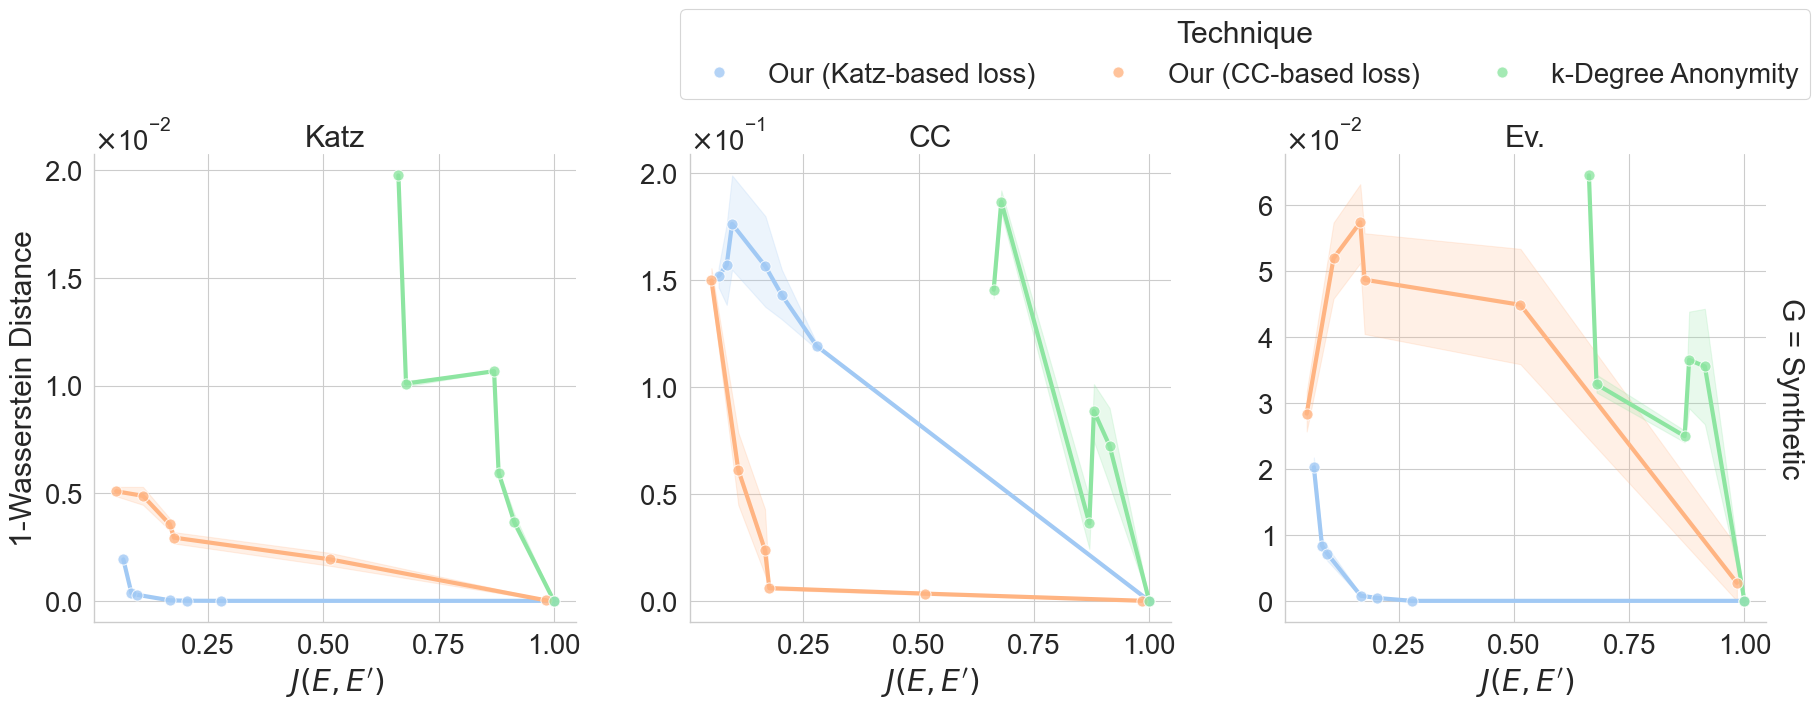

In [4]:
import seaborn as sns
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

def append_rows(samples, graph_name, method_names):
    for entry in samples:
        for method_name, metrics in entry.items():

            new_row = {"full_method_name": method_name, "G":graph_name}

            for name in method_names:
                if name in method_name:
                    new_row["method_type"] = name

            for metric, value in metrics.items():
                if isinstance(value, dict):
                    new_row[metric] = value['Ga']
                else:
                    new_row[metric] = value

            flat_rows.append(new_row)

def append_origin_rows(flat_rows, graph_name):
    flat_rows.append({"Katz": 0, "Ev.":0, "CC":0, "EJacc":1, "method_type": "Eager", "G": graph_name, "full_method_name":"None"})
    flat_rows.append({"Katz": 0, "Ev.":0, "CC":0, "EJacc":1, "method_type": "Anonymity", "G":graph_name, "full_method_name":"None"})
    #flat_rows.append({"Katz": 0, "Ev.":0, "LCC":0, "EJacc":1, "method_type": "Edge Add/Del", "G":graph_name, "full_method_name":"None"})


with open('cache/closeness_synth.pkl', 'rb') as f:
    closeness_synth = pickle.load(f)

flat_rows = []
append_rows(closeness_synth, "Synthetic", method_names = ["Eager", "Anonymity", "Brute CC"])
append_origin_rows(flat_rows, "Synthetic")

print(len(closeness_synth))
df = pd.DataFrame(flat_rows)
df['EJacc'] = df.groupby(['G', 'full_method_name'])['EJacc'].transform('mean')

df_melted = df.melt(id_vars=['EJacc', 'method_type', 'G'],
                    value_vars=['Katz', 'CC', 'Ev.'],
                    var_name='Metric',
                    value_name='1-Wasserstein Distance')
pd.set_option('display.max_rows', None)


df_melted['method_type'] = df_melted['method_type'].replace('Anonymity', 'k-Degree Anonymity')
df_melted['method_type'] = df_melted['method_type'].replace('Eager', 'Our (Katz-based loss)')
df_melted['method_type'] = df_melted['method_type'].replace('Brute CC', 'Our (CC-based loss)')

sns.set_theme(style="whitegrid", context='paper', palette='pastel', font_scale=2.25)

height = 6.4
g = sns.FacetGrid(df_melted, row="G", col="Metric", hue='method_type', sharey=False, height=height, aspect=2.5/height, margin_titles=True, despine=True)

g.map(sns.lineplot, "EJacc", "1-Wasserstein Distance", linewidth = 3, alpha = 1, err_kws={"alpha":0.2}, errorbar=('ci', 95))
g.map(sns.lineplot, "EJacc", "1-Wasserstein Distance", marker="o", markersize=8, alpha=0.8, linewidth = 0, err_kws={"alpha":0})

g.set_axis_labels("$J(E,E')$", "1-Wasserstein Distance")
g.set_titles(col_template="{col_name}")
g.add_legend(title='Technique', loc= 'upper center', bbox_to_anchor=(0.69, 1.15), ncol=3,frameon=True)
plt.tight_layout()

for ax in g.axes.flatten():
    ax.yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

plt.savefig("figures/Experiment_4_plot.pdf", bbox_inches="tight")
plt.show()
